# Projection-based model-order reduction for nonlinear heat conduction in 1D
Jean C. Ragusa

Texas A&M University

jean.ragusa@tamu.edu


# General Problem definition

###### you can easily more the problem more nonlinear by changing the temperature dependence of $k$ on $T$

Consider a 1D **nonlinear** heat conduction problem
$$ -\frac{d}{dx} k(x,T)\frac{dT}{dx} = q(x)
$$
where the conductivity is a function of temperature $$k(x,T)=k^0(x) + k^1(x)T$$
Hence, we are solving:
$$ -\frac{d}{dx} (k^0(x) + k^1(x) T)\frac{dT}{dx} = q(x)
$$
Boundary conditions:
- reflective at $x=0$: $\quad \left.\tfrac{dT}{dx}\right|_0 = 0$
- imposed temperature (Dirichlet bc) at $x=L$: $\quad T(L)=T_{bc}$

Linear version of the problem: set $k^1(x) = 0$

# Linear problem with zone-wise properties
Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 0.4]\end{equation} | 1.37142857  | 3500. |  
| II | \begin{equation}x \in [0.4, 0.5]\end{equation} | 2.          |   50. | 


### load python modules

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import time

# 1-D slab mesh and material properties
We give material properties "per zone" and then replicate them as many times as needed to assign them to a mesh cell (mesh resolution is a refinement of the material zone layout).

In [170]:
def create_slab_mesh(n_ref,zone_widths):
    # input: 
    #    n_ref: integer (how many times each zone is to be refined)
    #    zone_widths: array of zone widths
    # output:
    #    x: array of cell interface positions
    #    zone_widths: array of cell widths
    #    cell2mat: given a cell index, this returns the material ID in that cell
    
    if len(zone_widths) != len(n_ref):
        raise ValueError("dx and nref should have same length")
    
    # compute cell widths
    dx = np.repeat(zone_widths/n_ref, n_ref)
    
    # cell interfaces
    x = np.zeros(len(dx)+1)
    for i in range(len(dx)):
        x[i+1] = x[i] + dx[i]
        
    # create cell2mat array
    cell2mat = np.repeat( np.arange(len(zone_widths)), n_ref)
    
    # middle point
    xm = 0.5 * (x[1:]+x[:-1])
    
    return x, xm, dx, cell2mat

cell interfaces= [0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


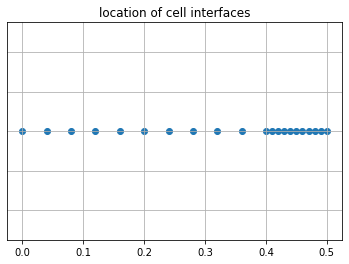

In [171]:
# small demo:
x, xm, dx, cell2mat = create_slab_mesh(n_ref=np.array([10,10],dtype=int),zone_widths=np.array([0.4,0.1]))

print('cell interfaces=',x)
# plot
plt.figure()
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none') 
plt.scatter(x, np.zeros(len(x)))
plt.title('location of cell interfaces')
plt.grid()
plt.show()

# Linear portion of the problem: matrix
We write a **vertex-centered** simple finite difference for the **linear** term $-\frac{d}{dx}k^0\frac{dT}{dx} = q$

Or,
$$
-k^0_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k^0_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$
where the full integer indices denote nodal (vertex) values and the half-integer indices denote cell values. $\Delta x_{i+1/2}=x_{i+1}-x_i$.

Finally, the last row simply encodes the Dirichlet boundary condition $A_{N,N} T_N=T_{Dirichlet}$ with $A_{N,N}=1$.
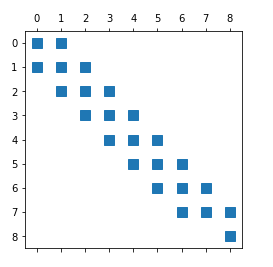

Resulting linear system:
$$ A T = b$$
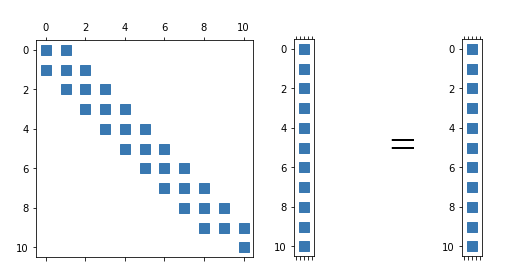

# Affine decomposition of the A matrix operator
Because the material property can be piece-wise constant per zone, the matrix $A$ representing $-\frac{d}{dx}k^0\frac{d}{dx}$
can be written as
$$
A(k^0) = \sum_{imat=1}^{Nmat} k^0_{imat} A_{imat} + A_{bc}
$$
where $A_{imat}$ corresponds to the portion of the matrix related to zone imat
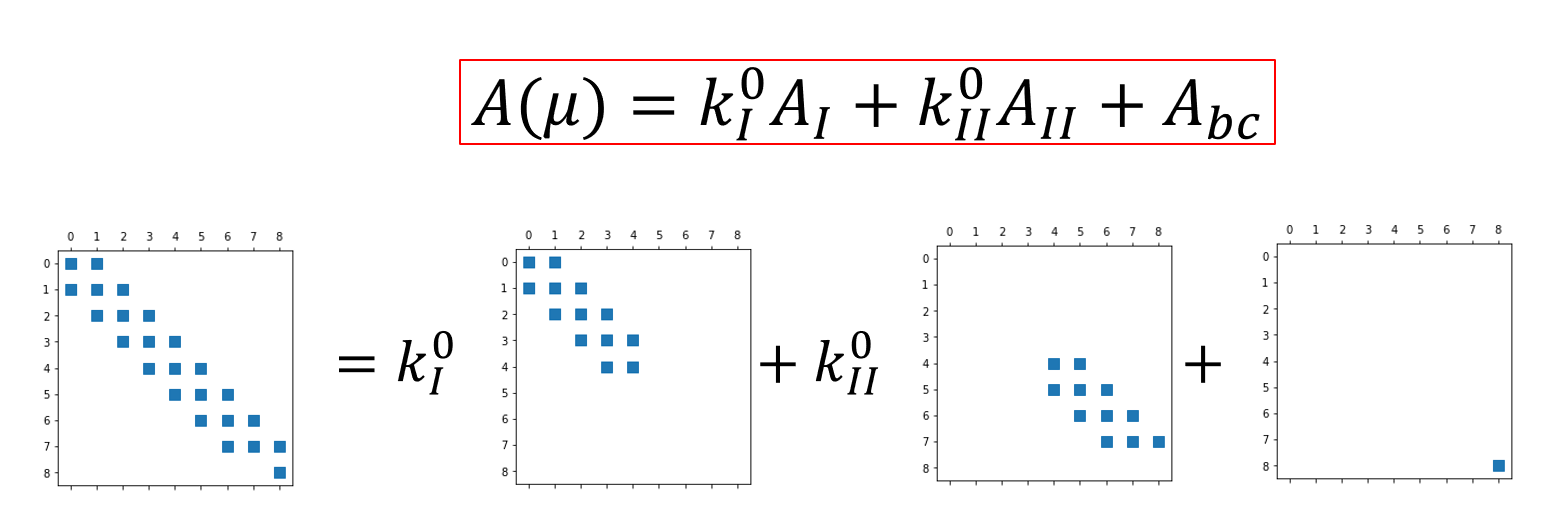

The routine below computes each of the $A_{imat}$ and $A_{bc}$ individually

In [172]:
def build_matrix_per_zone(bc, dx, mat2cell, verbose=False):
    # input: 
    #    cond_arr: conductivity array (length = number of material zones)
    #    xm   : array of cell middle points (length = number of cells)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    K: matrix

    t0 = time.time()
    
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # matrix list
    K_list = []
    M_list = []
    # get list of unique material IDs
    mat_list = np.unique(mat2cell)
    
    for imat in mat_list:
        cond = np.zeros(n_cells)
        mask = (mat2cell==imat)
        cond[mask] = 1.
 
        # matrix
        K = sparse.lil_matrix((n_pts,n_pts))
        for i in range(0,n_pts):
            if i>0:
                K[i,i-1] = -cond[i-1]/dx[i-1]
                K[i,i  ] = cond[i-1]/dx[i-1]
            if i<n_pts-1:
                K[i,i+1] = -cond[i  ]/dx[i  ]
                K[i,i  ]+= cond[i]/dx[i]
        # apply left bc
        if bc["left"]["type"] == "dirichlet":
            K[0,:2] = 0.

        # apply right bc
        if bc["right"]["type"] == "dirichlet":
            K[-1,-2:] = 0.            

        # save in list
        # Important. Use CSC for speed
        K_list.append(K.tocsc())

    # create sparse bc matrix
    K_bc = []
    
    # apply left bc
    K = sparse.lil_matrix((n_pts,n_pts))
    if bc["left"]["type"] == "natural":
        K[0,0] = 1. #bc["left"]["value_a"]
    elif bc["left"]["type"] == "dirichlet":
        K[0,0] = 1.    
    # save in list
    K_bc.append(K.tocsc())

    # apply right bc
    K = sparse.lil_matrix((n_pts,n_pts))
    if bc["right"]["type"] == "natural":
        K[-1,-1] = 1. #bc["right"]["value_a"]
    elif bc["right"]["type"] == "dirichlet":
        K[-1,-1] = 1. 
    # save in list
    K_bc.append(K.tocsc())
    
    if verbose:
        print("time spent in build_matrix_per_zone = ",time.time()-t0)
      
    return K_list, K_bc

#### This routine just performs the summation
$$
A(k^0) = \sum_{imat=1}^{Nmat} k^0_{imat} A_{imat} + A_{bc}
$$

In [262]:
def combine_matrix_per_zone(cond_arr, bc, K_list, K_bc, verbose=False):
    # input: 
    #    matprop_: material property array (length = number of material zones)
    #    K_list, M_list: list of finite-differnece matrices in sparse format, one per material zone
    # output:
    #    A: assembled finite-difference sparse matrix for the entire domain
    
    t0 = time.time()
    
    # Important. Use CSC for speed
    if isinstance(K_list[0], sparse.spmatrix):
        A = sparse.csc_matrix(K_list[0].shape)
    else:
        print(type(K_list[0]))
        A = np.zeros(K_list[0].shape)
    
    for imat,cond in enumerate(cond_arr):
        A += cond * K_list[imat]
    
    if bc["left"]["type"] == "natural":
        A += bc["left"]["value_a"] * K_bc[0]
    else:
        A += K_bc[0]
    if bc["right"]["type"] == "natural":
        A += bc["right"]["value_a"] * K_bc[-1]
    else:
        A += K_bc[-1]

    if verbose:
        print("time spent in combine_matrix_per_zone = ",time.time()-t0)

    return A

# rhs
These routines compute the RHS.

Affine decomposition can also be applied to the RHS, if desired:
$$
RHS(q) = \sum_{isrc=1}^{Nsrc} q_{imat} RHS_{isrc}
$$

In [263]:
def build_rhs_per_zone(bc, dx, mat2cell):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1

    rhs_list = []
    # get list of unique material IDs
    src_list = np.unique(mat2cell)
    
    for isrc in src_list:
        qext = np.zeros(n_cells)
        mask = (mat2cell==isrc)
        qext[mask] = 1.
        
        #  rhs
        rhs = np.zeros(n_pts)
        rhs[:-1] += qext*dx/2
        rhs[1:]  += qext*dx/2
    
        # apply left bc
        if bc["left"]["type"] == "dirichlet":
            rhs[0] = 0.
        # apply right bc
        if bc["right"]["type"] == "dirichlet":
            rhs[-1] = 0.

        rhs_list.append(rhs)

    rhs_bc =[]
    
    rhs = np.zeros(n_pts)
    rhs[0] = 1.
    rhs_bc.append(rhs)
    
    rhs = np.zeros(n_pts)
    rhs[-1] = 1.
    rhs_bc.append(rhs)
    
    return rhs_list, rhs_bc


def combine_rhs_per_zone(qext_arr, bc, rhs_list, rhs_bc):
    # input: 
    #    qext_: external source array (length = number of material zones)
    #    rhs_list: list of right-hand sides, one per material zone
    # output:
    #    rhs: assembled right-hand side for the entire domain

    rhs = np.zeros(len(rhs_list[0]))
    
    for isrc,q in enumerate(qext_arr):
        rhs += q * rhs_list[isrc]
        
    # apply left bc
    if bc["left"]["type"] == "natural":
        rhs += bc["left"]["value_c"] * rhs_bc[0]
    elif bc["left"]["type"] == "dirichlet":
        rhs += bc["left"]["value"] * rhs_bc[0]
    else:
        raise ValueError("unknown bc type on left")

    # apply right bc
    if bc["right"]["type"] == "natural":
        rhs += bc["right"]["value_c"] * rhs_bc[-1]
    elif bc["right"]["type"] == "dirichlet":
        rhs += bc["right"]["value"] * rhs_bc[-1]
    else:
        raise ValueError("unknown bc type on right")
            
    return rhs

# routines that build linear system and solves for $T$
Two options:
1. Build A and rhs at once (not done here at all)
2. Use the affine decomposition and combine


In [264]:
def solve_linear_combine(cond_arr, qext_arr, bc, K_list, K_bc, rhs_list, rhs_bc, verbose=False):  
    # build linear system           
    t0= time.time()
    A   = combine_matrix_per_zone(cond_arr, bc, K_list, K_bc)
    t1= time.time()
    rhs = combine_rhs_per_zone(qext_arr, bc, rhs_list, rhs_bc)
    t2= time.time()
    
    # solve linear system
    if sparse.isspmatrix_csc(A):
        if verbose:
            print("It's a CSC matrix.")
        T  = linalg.spsolve(A, rhs)   
    elif sparse.isspmatrix_lil(A):
        if verbose:
            print("It's a LIL matrix.")
        T  = linalg.spsolve(A.tocsc(), rhs)   
    elif isinstance(A, sparse.spmatrix):
        if verbose:
            print("It's a generic sparse matrix.")
        T  = linalg.spsolve(A.tocsc(), rhs)   
    elif isinstance(A, np.ndarray):
        if verbose:
            print("It's a NumPy ndarray.")
        T  = np.linalg.solve(A, rhs)   
    else:
        if verbose:
            print("It's not a recognized sparse matrix type or a NumPy ndarray.")    
    t3= time.time()
    if verbose:
        print('Build using affine-decomposed arrays + solve')
        print("time to assembleA= ",t1-t0)
        print("time to assembleb= ",t2-t1)
        print("time to solve    = ",t3-t2)
        print("total time       = ",t3-t0,"\n")
        
    return T

# Problem definition and linear solve

| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 0.4]\end{equation} | 1.37142857  | 3500. |  
| II | \begin{equation}x \in [0.4, 0.5]\end{equation} | 2.          |   50. | 





time spent in build_matrix_per_zone =  0.008745193481445312
It's a CSC matrix.
Build using affine-decomposed arrays + solve
time to assembleA=  0.0
time to assembleb=  0.0
time to solve    =  0.0
total time       =  0.0 



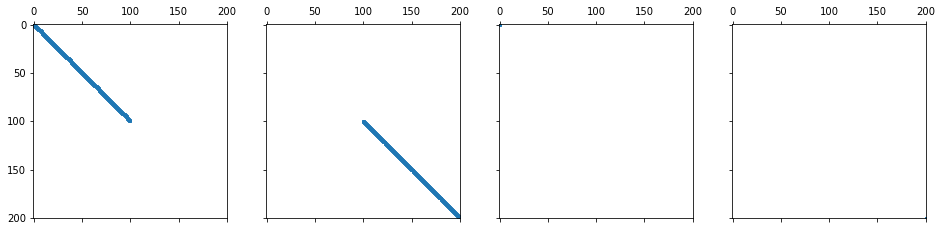

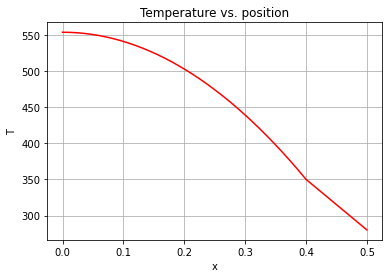

In [336]:
T_dir = 280.
# T_dir = 300.

cond0_arr= np.array([  1.37142857,  2.])
# cond0_arr= np.array([  0.5, 2.])
qext_arr = np.array([3500., 50.])
# qext_arr = np.array([350., 350.])

# width = np.array([  0.3, 0.5])
width = np.array([  0.4, 0.1])
n_ref = np.array([100, 100], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# boundary conditions
bc = {}
bc_sym = {"type": "natural", "value_a": 0., "value_c": 0.}
bc_dir = {"type": "dirichlet", "value": T_dir}
bc["left"]  = bc_sym
bc["right"] = bc_dir

K_list, K_bc = build_matrix_per_zone(bc, dx, mat2cell, verbose=True)
rhs_list, rhs_bc = build_rhs_per_zone(bc, dx, mat2cell)

fig, axs = plt.subplots(1, len(K_list+K_bc), sharey=True, figsize=(16,9))
axs = axs.flatten()
for ax,K in zip(axs,K_list+K_bc):
    ax.spy(K,ms=2)

# solve
T_lin = solve_linear_combine(cond0_arr, qext_arr, bc, K_list, K_bc, rhs_list, rhs_bc, verbose=True)

# plot
plt.figure()
plt.plot(x,T_lin,'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position')
plt.grid(True)

# Generate snapshots for linear case:
Split into training and testing sets

In [337]:
np.random.seed(123456789)
n_samples = 50

nominal_ = np.expand_dims(cond0_arr, axis=1)
n_inputs = 2

print('nominal values of param=',nominal_[:,0],"\n")
frac = 0.2
samples = np.random.uniform(low=nominal_*(1-frac), high=nominal_*(1+frac),size=(n_inputs,n_samples))
# transpose here to have the params as snapshots x nparam
samples = samples.T

n_train = int(0.8*n_samples)
n_test = n_samples - n_train
x_train = samples[:n_train,:]
x_test  = samples[n_train:,:]
print(x_train.shape,x_test.shape)
print(x_train)

nominal values of param= [1.37142857 2.        ] 

(40, 2) (10, 2)
[[1.38943983 2.13001071]
 [1.39015493 1.96662055]
 [1.37666909 1.68790111]
 [1.4885837  2.18395013]
 [1.23812514 2.22736285]
 [1.51004906 1.71303177]
 [1.58201372 2.27094955]
 [1.18211607 1.92218106]
 [1.46498547 1.92513893]
 [1.45011849 1.89653305]
 [1.49410405 2.33361249]
 [1.50787211 1.99254349]
 [1.54617457 2.3727907 ]
 [1.15085267 1.65577678]
 [1.09909243 1.88963892]
 [1.22375842 1.63612797]
 [1.10386567 1.86858999]
 [1.29108574 1.92574196]
 [1.19878298 1.7864857 ]
 [1.53203295 1.76299434]
 [1.43296294 2.34784176]
 [1.59054398 2.06163746]
 [1.27014461 2.09937737]
 [1.32022241 2.27437654]
 [1.63488472 1.74118738]
 [1.39450433 2.28061984]
 [1.23005876 1.83930824]
 [1.23551544 2.26753639]
 [1.40717117 2.36620658]
 [1.17028766 1.69178379]
 [1.57783326 1.69327102]
 [1.36063919 1.63660067]
 [1.25256733 2.06510057]
 [1.5865842  1.67842197]
 [1.55115811 1.77060411]
 [1.63472666 1.73774929]
 [1.57288209 2.3785189 ]
 [1.2032

## compute training set

Time spent generating snapshots =  0.05057477951049805 



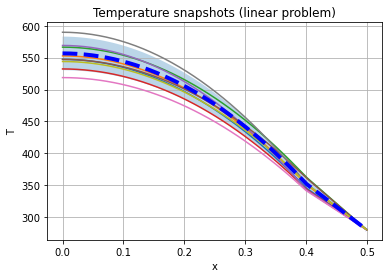

In [338]:
T_snapshots = np.zeros((len(x),n_samples))


t0 = time.time()
# loop to generate snapshots
for i in range(n_samples):
    # conductivity values per zone
    # external volumetric heat source values per zone
    cond_arr = samples[i,:]

    # solve
    T_snapshots[:,i] = solve_linear_combine(cond_arr, qext_arr, bc, K_list, K_bc, rhs_list, rhs_bc)
        

print("Time spent generating snapshots = ",time.time()-t0,"\n")    

mean_temp = np.mean(T_snapshots,axis=1)
std_temp  = np.std(T_snapshots,axis=1)

plt.figure()
for i in range(9):
    plt.plot(x,T_snapshots[:,i])
plt.xlabel('x')
plt.ylabel('T')
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.3)
plt.title('Temperature snapshots (linear problem)')
plt.grid(True)

# SVD
Data matrix $D_T$ is the training set of solution snapshots.

Perform 
$$ D_T = U_T \Sigma_T V_T^t $$

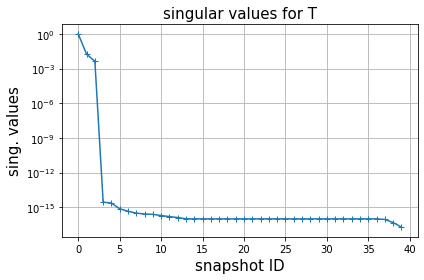

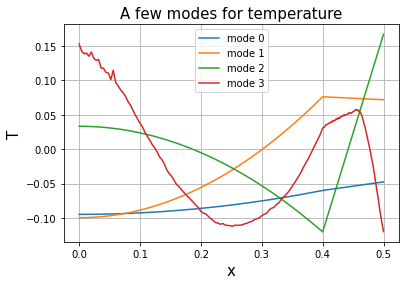

In [339]:
U_all, S, _ = np.linalg.svd(T_snapshots[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(6,4))
plt.semilogy(S/np.max(S),'-+')
plt.xlabel('snapshot ID',fontsize=15)
plt.ylabel('sing. values',fontsize=15)
plt.title('singular values for T',fontsize=15)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
for i in range(4):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('T',fontsize=15)
plt.show()

## Select rank

In [340]:
rU = 3
U = U_all[:,:rU]
print(U.shape)

(201, 3)


# Create intrusive ROM
We use affine decomposition here. Thus, the original system of equations (without the nonlinear term) is (matrix size $N\times N$)
$$ A(\mu) T^{\mu} = b(\mu)$$
It gets Galerkin-projected into
$$ U_T^tA(\mu) U_T c^{\mu} = U_T^tb(\mu)$$
where we used the fact that the new solution is sought as
$$ T^{\mu} = U_T c^{\mu} = \sum_{i=1}^{i=r} u_i c_i^{\mu}$$
with $u_i$ the global basis (vectors of same length as the $T$ vector) and $c_i^{\mu}$ the expansion coefficients that depend on the new parameter $\mu$. $r$ is the rank retained in our approximation.


Note that the above projected system is a system of much smaller size (matrix size $r\times r$)
$$ A_r(\mu) c^{\mu} = b_r(\mu)$$
with
$$ A_r(\mu) = U_T^tA(\mu) U_T \qquad b_r(\mu)= U_T^tb(\mu)$$

Reconstruction part: once the $r$ coefficients $c_i^{\mu}$ ($1\le i \le r$) are obtained, the full-length solution is given by $ T^{\mu} = U_T c^{\mu}$

## Compute the reduced operators for the affine decomposition approach (linear operator and rhs only)

In [341]:
def compute_reduced_operator_affine(U, K_list, K_bc, rhs_list, rhs_bc):

    Kr_list = []
    for K in K_list:
        Kr_list.append( U.T @ K @ U )

    Kr_bc = []
    for K in K_bc:
        Kr_bc.append( U.T @ K @ U )
    # u_last= U[-1,:]
    # Ar_bc = np.outer(u_last, u_last)

    rhsr_list = []
    for rhs in rhs_list:
        rhsr_list.append( U.T @ rhs )

    rhsr_bc = []
    for rhs in rhs_bc:
        rhsr_bc.append( U.T @ rhs )

    return Kr_list, Kr_bc, rhsr_list, rhsr_bc

#### do not forget to compute the reduced operator once the rank/subspace has been selected

In [342]:
Kr_list, Kr_bc, rhsr_list, rhsr_bc = compute_reduced_operator_affine(U, K_list, K_bc, rhs_list, rhs_bc)

##### here's the ROM solver:

In [343]:
def solve_intrusive_rom_affine(U, sample, bc, Kr_list, Kr_bc, rhsr_list, rhsr_bc):
    cond_arr = sample[:]
    # solve
    c = solve_linear_combine(cond_arr, qext_arr, bc, Kr_list, Kr_bc, rhsr_list, rhsr_bc)
    # reconstruct
    T_recons = U @ c

    return T_recons

## Build and solve linear ROM for a random sample

<class 'numpy.ndarray'>


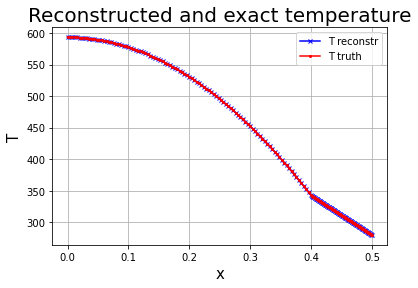

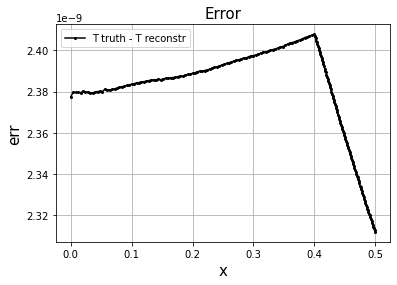

In [344]:
my_sample=45
k0 = samples[my_sample]

# solve
T_rec = solve_intrusive_rom_affine(U, k0, bc, Kr_list, Kr_bc, rhsr_list, rhsr_bc)
T_truth = T_snapshots[:,my_sample]

plt.figure(figsize=(6,4))
plt.plot(x,T_rec,'-xb',ms=4,label='T reconstr')
plt.plot(x,T_truth,'-or',ms=2,label='T truth')
plt.grid(True)
plt.legend()
plt.title('Reconstructed and exact temperature',fontsize=20)
plt.xlabel('x',fontsize=15)
plt.ylabel('T',fontsize=15)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x,T_truth-T_rec,'-ok',ms=2,label='T truth - T reconstr')
plt.grid(True)
plt.legend()
plt.title('Error',fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('err',fontsize=15)
plt.show()

# Now, the nonlinear part of the problem

We solve
$$ -\frac{d}{dx} (k^0(x) + k^1(x) T)\frac{dT}{dx} = q(x)
$$

After finite-difference discretization, we obtain a full-order nonlinear system that we write as

$$
A(\mu)T(\mu) + F(T(\mu)) = b(\mu)
$$


| Zone ID | $x$   | \begin{equation}k^0\end{equation}  | \begin{equation}k^1\end{equation} | $q$ |
| :---    | :---: | ---:  | ---:  | --- |
| I  | \begin{equation}x \in [0.0, 0.4]\end{equation} | 1.37142857  | -0.00057143 | 3500. |  
| II | \begin{equation}x \in [0.4, 0.5]\end{equation} | 2.          | 0.          |   50. |



In [345]:
cond1_arr   = np.array([ -0.00057143 ,  0.])
# cond1_arr   = np.array([ 0.005 ,  -0.0005])

## Routine that builds the non-linear contribution to the now nonlinear system of equations


In [346]:
def build_nonlinear_term(cond1_arr, T, bc, dx, mat2cell):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # evaluate mat property per cell
    cond = cond1_arr[mat2cell]
    T_ave = (T[:-1] + T[1:])/2
    cond = cond*T_ave

    # matrix
    K = sparse.lil_matrix((n_pts,n_pts))
    for i in range(0,n_pts):
        if i>0:
            K[i,i-1] = -cond[i-1]/dx[i-1]
            K[i,i  ] = cond[i-1]/dx[i-1]
        if i<n_pts-1:
            K[i,i+1] = -cond[i  ]/dx[i  ]
            K[i,i  ]+= cond[i]/dx[i]
    
    # apply left bc (mostly do nothing as this is usually done in the linear portion of the operator)
    if bc["left"]["type"] == "dirichlet":
        K[0,:2] = 0.
        # K[0,0]  = 1.
#     elif bc["left"]["type"] == "natural":
#          K[0,0] += bc["left"]["value_a"]
        
    # apply right bc
    if bc["right"]["type"] == "dirichlet":
        K[-1,-2:] = 0.
        # K[-1,-1]  = 1.
#     elif bc["right"]["type"] == "natural":
#         K[-1,-1] += bc["right"]["value_a"]

    return K@T

## Solution to the nonlinear system of equations

In [347]:
from scipy.optimize import fsolve

def solve_nonlinear(cond0_arr, cond1_arr, qext_arr, bc, T_init, dx, mat2cell, \
                    K_list, K_bc, rhs_list, rhs_bc, verbose=False):  

    A   = combine_matrix_per_zone(cond0_arr, bc, K_list, K_bc)
    rhs = combine_rhs_per_zone(qext_arr, bc, rhs_list, rhs_bc)

    F = lambda T: build_nonlinear_term(cond1_arr, T, bc, dx, mat2cell)

    f = lambda T: A@T + F(T) - rhs

    # make sure the initial guess satisfies the Dirichlet BC
    if bc["left"]["type"] == "dirichlet":
        T_init[0] = bc["left"]["value"]
    # apply right bc
    if bc["right"]["type"] == "dirichlet":
        T_init[-1] = bc["right"]["value"]

    # solve
    T  = fsolve(f, T_init)
    
    return T

## solve and plot

In [348]:
L1,L = width[0],np.sum(width)
con1,con2 = cond0_arr
q1,q2 = qext_arr
d = (q1-q2)*L1/con2
c = q1/con1/2*L1**2+q2/con2/2*(L**2-L1**2)+d*(L-L1)+T_dir
exact = lambda x: (-q1/con1/2*x**2 + c)*(x<L1) + (q2/con2/2*(L**2-x**2) + d*(L-x)+T_dir)*(x>=L1)

Max T value =  605.0106108788045


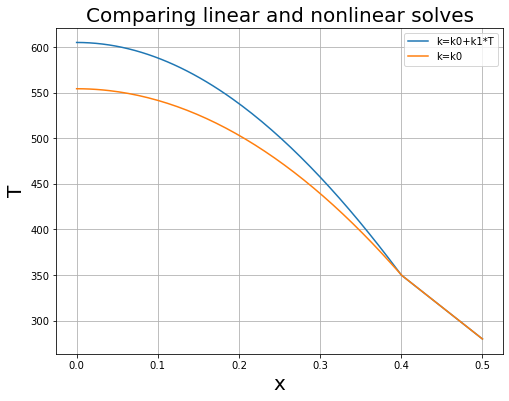

In [349]:
T_init = np.zeros(len(x))
T_lin =solve_linear_combine(cond0_arr, qext_arr, bc, K_list, K_bc, rhs_list, rhs_bc)
T_nonlin = solve_nonlinear(cond0_arr, cond1_arr, qext_arr, bc, T_init, dx, mat2cell, \
                    K_list, K_bc, rhs_list, rhs_bc)
print('Max T value = ',np.max(T_nonlin))

plt.figure(figsize=(8,6))
plt.plot(x,T_nonlin, label='k=k0+k1*T')

plt.plot(x,T_lin, label='k=k0')
# plt.plot(x,exact(x), label='exact k=k0')

plt.grid(True)
plt.legend()
plt.title('Comparing linear and nonlinear solves',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.show()

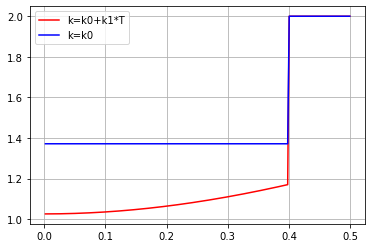

In [350]:
cond_lin = cond0_arr[mat2cell]
Tm = (T_nonlin[:-1]+T_nonlin[1:])/2
cond_nl = cond0_arr[mat2cell] + cond1_arr[mat2cell] *Tm

plt.figure()
plt.plot(xm,cond_nl,'r', label='k=k0+k1*T')
plt.plot(xm,cond_lin,'b',label='k=k0')
plt.legend()
plt.grid(True)

# Generate snapshots for the nonlinear problem

In [351]:
np.random.seed(123456789)
n_samples = 50

# mean_ = np.expand_dims(np.append(k0_,k1_)        ,axis=1)
# std_  = np.expand_dims(np.append(k0_*0.2,k1_*0.15),axis=1)
# samples = np.random.normal(loc=mean_,scale=std_,size=(4,n_samples))
nominal_ = np.expand_dims(np.append(cond0_arr,cond1_arr), axis=1)
print('nominal values of param=',nominal_[:,0])
frac = 0.2
samples = np.random.uniform(low=nominal_*(1-frac), high=nominal_*(1+frac),size=(4,n_samples))
# transpose here to have the params as snapshots x nparam
samples = samples.T

n_train = int(0.8*n_samples)
n_test = n_samples - n_train
x_train = samples[:n_train,:]
x_test  = samples[n_train:,:]
print(x_train.shape,x_test.shape)
print(x_train)

nominal values of param= [ 1.37142857e+00  2.00000000e+00 -5.71430000e-04  0.00000000e+00]
(40, 4) (10, 4)
[[ 1.38943983e+00  2.13001071e+00 -6.20012492e-04  0.00000000e+00]
 [ 1.39015493e+00  1.96662055e+00 -4.95330179e-04  0.00000000e+00]
 [ 1.37666909e+00  1.68790111e+00 -5.14044635e-04  0.00000000e+00]
 [ 1.48858370e+00  2.18395013e+00 -6.47811561e-04  0.00000000e+00]
 [ 1.23812514e+00  2.22736285e+00 -6.42994629e-04  0.00000000e+00]
 [ 1.51004906e+00  1.71303177e+00 -5.63691800e-04  0.00000000e+00]
 [ 1.58201372e+00  2.27094955e+00 -5.82396282e-04  0.00000000e+00]
 [ 1.18211607e+00  1.92218106e+00 -6.13353052e-04  0.00000000e+00]
 [ 1.46498547e+00  1.92513893e+00 -5.69842947e-04  0.00000000e+00]
 [ 1.45011849e+00  1.89653305e+00 -6.19124141e-04  0.00000000e+00]
 [ 1.49410405e+00  2.33361249e+00 -6.17969516e-04  0.00000000e+00]
 [ 1.50787211e+00  1.99254349e+00 -5.57212161e-04  0.00000000e+00]
 [ 1.54617457e+00  2.37279070e+00 -5.03615198e-04  0.00000000e+00]
 [ 1.15085267e+00  1.6

## compute training set

In [352]:
Usnap = np.zeros((len(x),n_samples))
Fsnap = np.zeros((len(x),n_samples))

for i in range(n_samples):
    print('working on sample ',i)
    k0, k1 = samples[i,:2], samples[i,2:]
    Usnap[:,i] = solve_nonlinear(k0, k1, qext_arr, bc, T_init, dx, mat2cell, \
                    K_list, K_bc, rhs_list, rhs_bc)
    Fsnap[:,i] = build_nonlinear_term(k1, Usnap[:,i], bc, dx, mat2cell)

working on sample  0
working on sample  1
working on sample  2
working on sample  3
working on sample  4
working on sample  5
working on sample  6
working on sample  7
working on sample  8
working on sample  9
working on sample  10
working on sample  11
working on sample  12
working on sample  13
working on sample  14
working on sample  15
working on sample  16
working on sample  17
working on sample  18
working on sample  19
working on sample  20
working on sample  21
working on sample  22
working on sample  23
working on sample  24
working on sample  25
working on sample  26
working on sample  27
working on sample  28
working on sample  29
working on sample  30
working on sample  31
working on sample  32
working on sample  33
working on sample  34
working on sample  35
working on sample  36
working on sample  37
working on sample  38
working on sample  39
working on sample  40
working on sample  41
working on sample  42
working on sample  43
working on sample  44
working on sample  4

### plot some snapshots


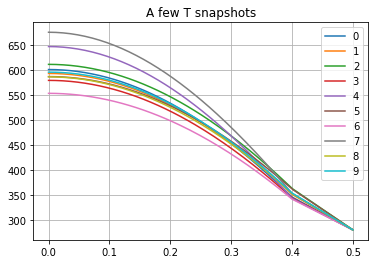

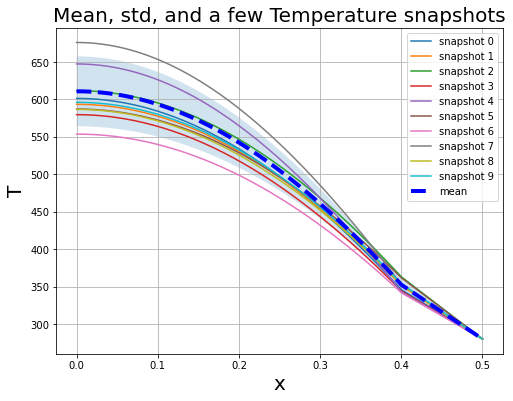

In [353]:
n_samples_plot = min(n_samples,10)
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label=str(i))
plt.grid(True)
plt.legend()
plt.title('A few T snapshots')
plt.show()

mean_temp = np.mean(Usnap,axis=1)
std_temp  = np.std(Usnap,axis=1)
plt.figure(figsize=(8,6))
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label='snapshot '+str(i))
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.2)
plt.grid(True)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.legend()
plt.title('Mean, std, and a few Temperature snapshots',fontsize=20)
plt.show()

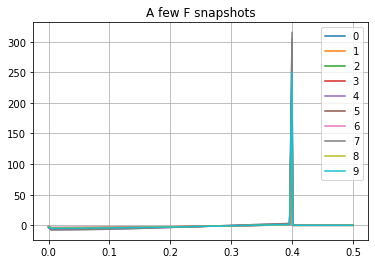

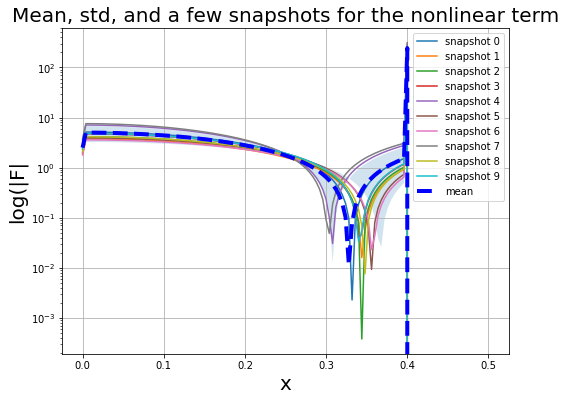

In [354]:
n_samples_plot = min(n_samples,10)
for i in range(n_samples_plot):
    plt.plot(x,Fsnap[:,i],label=str(i))
plt.grid(True)
plt.legend()
plt.title('A few F snapshots')
plt.show()

mean_temp = np.mean(Fsnap,axis=1)
std_temp  = np.std(Fsnap,axis=1)
plt.figure(figsize=(8,6))
for i in range(n_samples_plot):
    plt.semilogy(x,np.abs(Fsnap[:,i]),label='snapshot '+str(i))
plt.semilogy(x,np.abs(mean_temp),'b--', linewidth=4, label='mean')
plt.fill_between(x,np.abs(mean_temp-std_temp),np.abs(mean_temp+std_temp),alpha=.2)
plt.grid(True)
plt.legend()
plt.xlabel('x',fontsize=20)
plt.ylabel('log(|F|',fontsize=20)
plt.legend()
plt.title('Mean, std, and a few snapshots for the nonlinear term',fontsize=20)
plt.show()

# SVD
Data matrix $D_T$ is the training set of solution snapshots.

Perform 
$$ D_T = U_T \Sigma_T V_T^t $$

Data matrix $D_F$ is the training set of nonlinear term snapshots.

Perform 
$$ D_F = U_F \Sigma_F V_F^t $$

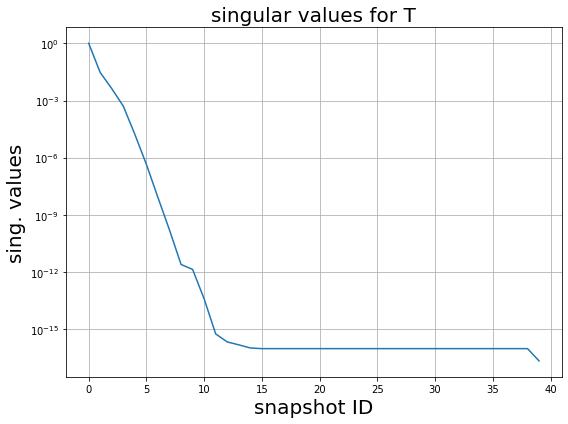

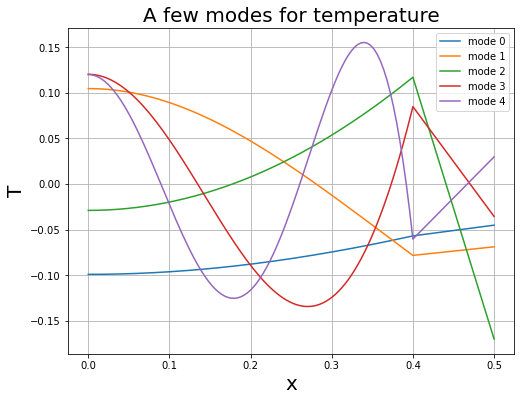

In [355]:
U_all, S, _ = np.linalg.svd(Usnap[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(S/np.max(S))
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for T',fontsize=20)
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.show()

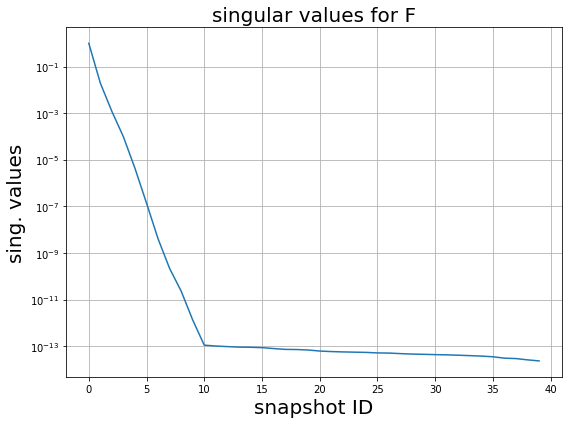

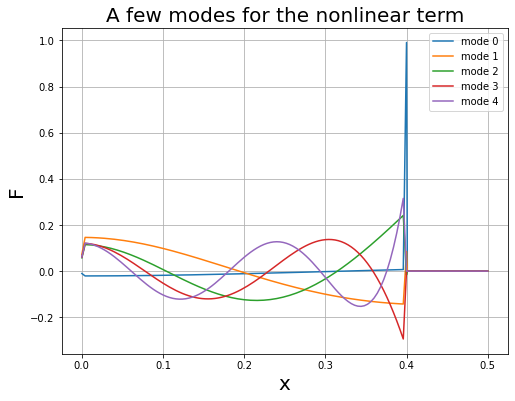

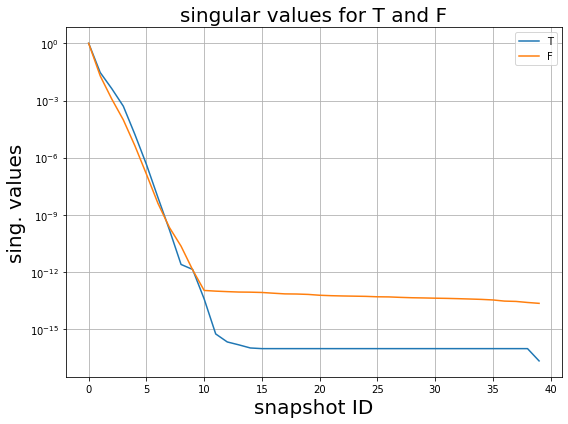

In [356]:
V_all, SF, _ = np.linalg.svd(Fsnap[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(SF/np.max(SF))
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for F',fontsize=20)
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(x,V_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for the nonlinear term',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('F',fontsize=20)
plt.show()

plt.figure(figsize=(8,6))
plt.semilogy(S /np.max(S ),label='T')
plt.semilogy(SF/np.max(SF),label='F')
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for T and F',fontsize=20)
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()


## select ranks

In [368]:
rU = 4
rF = 3
U = U_all[:,:rU]
V = V_all[:,:rF]
print(U.shape)
print(V.shape)

(201, 4)
(201, 3)


# create intrusive ROM (linear part)
We use affine decomposition here. Thus, the original system of equations (without the nonlinear term) is (matrix size $N\times N$)
$$ A(\mu) T^{\mu} = b(\mu)$$
It gets Galerkin-projected into
$$ U_T^tA(\mu) U_T c^{\mu} = U_T^tb(\mu)$$
where we used the fact that the new solution is sought as
$$ T^{\mu} = U_T c^{\mu} = \sum_{i=1}^{i=r} u_i c_i^{\mu}$$
with $u_i$ the global basis (vectors of same length as the $T$ vector) and $c_i^{\mu}$ the expansion coefficients that depend on the new parameter $\mu$. $r$ is the rank retained in our approximation.


Note that the above projected system is a system of much smaller size (matrix size $r\times r$)
$$ A_r(\mu) c^{\mu} = b_r(\mu)$$
with
$$ A_r(\mu) = U_T^tA(\mu) U_T \qquad b_r(\mu)= U_T^tb(\mu)$$

Reconstruction part: once the $r$ coefficients $c_i^{\mu}$ ($1\le i \le r$) are obtained, the full-length solution is given by $ T^{\mu} = U_T c^{\mu}$

# compute the reduced operators for the affine decomposition approach (linear operator and rhs only)

In [369]:
def compute_reduced_operator_affine(U, K_list, K_bc, rhs_list, rhs_bc):

    Kr_list = []
    for K in K_list:
        Kr_list.append( U.T @ K @ U )

    Kr_bc = []
    for K in K_bc:
        Kr_bc.append( U.T @ K @ U )
    # u_last= U[-1,:]
    # Ar_bc = np.outer(u_last, u_last)

    rhsr_list = []
    for rhs in rhs_list:
        rhsr_list.append( U.T @ rhs )

    rhsr_bc = []
    for rhs in rhs_bc:
        rhsr_bc.append( U.T @ rhs )

    return Kr_list, Kr_bc, rhsr_list, rhsr_bc

In [370]:
Kr_list, Kr_bc, rhsr_list, rhsr_bc = compute_reduced_operator_affine(U, K_list, K_bc, rhs_list, rhs_bc)

## DEIM  (nonlinear part)
When a nonlinear term is present, the full-order nonlinear solve is:
$$ A(\mu) T^{\mu} +F(T^{\mu};\mu) - b(\mu) = 0$$

We collect snapshots of $T^{\mu}$ but also of $F(T^{\mu};\mu)$.

We perform an SVD for the temperature snapshots
$$ D_T = U_T \Sigma_T V_T^T $$
and the nonlinear term snapshots
$$ D_F = U_F \Sigma_F V_F^T $$

We Galerkin project the nonlinear system of equations
$$ U_T^tA(\mu) U_T c_T^{\mu} +U_T^t F(U_Tc_T^\mu;\mu)- U_T^tb(\mu) = 0$$

This yields the reduced nonlinear system
$$A_r(\mu) c_T^{\mu} + U_T^t F(U_Tc_T^\mu;\mu)- b_r(\mu) = 0$$
but the nonlinear term still apperently requires a full-order level evaluation.

In DEIM, we compute
$$F(U_Tc_T) \approx U_F (P^t U_F)^{-1} P^t F(U_Tc)$$
- Matrix $M=U_T^t U_F (P^t U_F)^{-1}$ can be computed once for all.
- $P^t F(U_Tc)$ is just a selection of a few rows of $F$ based on the selector matrix $P$.


In [371]:
def DEIM_SVD(u_in):
    [n, r] = np.shape(u_in)
    print(n,r)
    P, list_ind = np.zeros([n,r]), np.zeros(r,dtype=int)
    
    ind = np.argmax(np.abs(u_in[:, 0]))
    
    print('DEIM Cycle: ', 0)
    P[ind,0] = 1
    BB = np.expand_dims(u_in[:,0],axis=1)
    list_ind[0]= ind
    
    for i in range(1,r):
        print('DEIM Cycle: ', i)
        P_loc, u_i = P[:,:i], u_in[:,i]        
        mat = P_loc.T @ BB
        rhs = P_loc.T @ u_i
        c = np.linalg.solve(mat, rhs)
        residual = u_i - BB@c
        ind = np.argmax(np.abs(residual))
        BB = np.hstack((BB, np.expand_dims(u_i,axis=1)))
        P[ind,i] = 1
        list_ind[i] = ind
    print(list_ind)
    phi = np.sort(list_ind[:r]).astype(int)
    P2 = np.zeros([n,r])
    for j,i in enumerate(phi):
        P2[i,j]=1
    
    return P[:,:r],list_ind

In [372]:
P,list_ind = DEIM_SVD(V)

201 3
DEIM Cycle:  0
DEIM Cycle:  1
DEIM Cycle:  2
[100   1  99]


## precompute matrix for DEIM once for all:

In [373]:
M = U.T @ V @ np.linalg.inv(P.T@V)
print(M.shape)

(4, 3)


### DEIM residual

Here, for index $i$, we just need to retrieve the $i$th row of $F$ (let's call it $F_i$). We only need to evaluate the nonlinear residual there because this is what the selector matrix $P$ is actually doing, so **no full-order** complexity operations (only very local portions of the nonlinear residual are needed)

Any row $F_i$ depends on the latest nonlinear estimate of temperature at nodes $i-1$, $i$, and $i+1$. 

This is a simple finite difference of the term $-\frac{d}{dx}k^1 T\frac{dT}{dx}$

Or,
$$
-\delta _{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
\delta _{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
$$
where $T$ is actually $Uc$ and $\delta _{i+1/2} = k^1_{i+1/2} T_{i+1/2} $

In [374]:
def deim_res(c,cond1_arr,cell2mat,list_ind,U):
    
    n_pts, r = U.shape
    out = np.zeros(len(list_ind))

    for i in range(len(list_ind)):
        
        if list_ind[i]==n_pts-1: # on the boundary node
            out[i] = 0
        
        elif list_ind[i]==0: # on the symmetry node
            gn = [0,1]
            Uc = U[gn,:] @ c           # (2xr) x (rx1) = (2x1)

            Uc_rite = np.mean(Uc)
            k1_rite = cond1_arr[cell2mat[0]]
            cond_rite = k1_rite*Uc_rite
            oper = cond_rite/dx[0] * np.array([-1., 1.])
            
            out[i] = oper @ Uc  # (1x2) x (2x1)
        
        else: # all other nodes
            gn = list_ind[i] + [-1, 0, 1]
            Uc = U[gn,:]@c                      # (3xr) x (rx1) = (3x1)
            
            Uc_rite = np.mean(Uc[1:])
            cell_id = list_ind[i] 
            k1_rite = cond1_arr[cell2mat[cell_id]]
            cond_rite = k1_rite*Uc_rite
            oper = -cond_rite/dx[cell_id] * np.array([0, -1., 1.])

            Uc_left = np.mean(Uc[:2])
            cell_id = list_ind[i] - 1
            k1_left = cond1_arr[cell2mat[cell_id]]
            cond_left = k1_left*Uc_left

            oper += cond_left/dx[cell_id] * np.array([-1., 1., 0.])

            out[i] = oper @ Uc  # (1x3) x (3x1)

    return out

## Testing point not in training set

<class 'numpy.ndarray'>


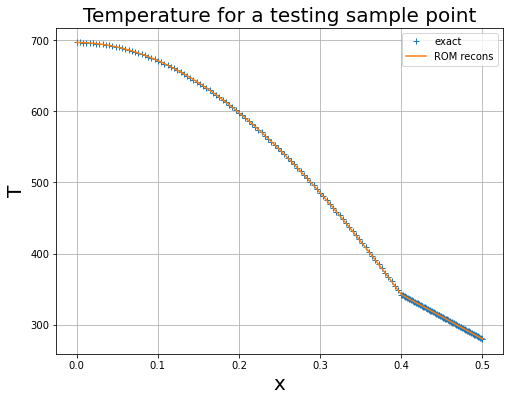

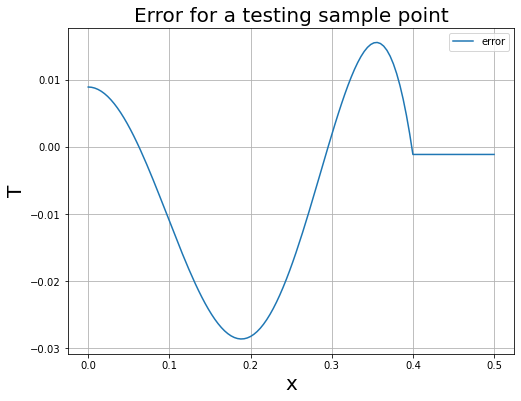

In [375]:
my_sample=45
k0, k1 = samples[my_sample,:2], samples[my_sample,2:]

Ar   = combine_matrix_per_zone(k0, bc, Kr_list, Kr_bc)
qr = combine_rhs_per_zone(qext_arr, bc, rhsr_list, rhsr_bc)

   
fr = lambda c: Ar@c + M@deim_res(c,k1,mat2cell,list_ind,U) - qr
# solve
c_init = np.linalg.solve(Ar,qr)
c  = fsolve(fr, c_init)

plt.figure(figsize=(8,6))
plt.plot(x,Usnap[:,my_sample],'+',label='exact')
plt.plot(x,U@c,label='ROM recons')
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.title('Temperature for a testing sample point',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x,Usnap[:,my_sample]-U@c,label='error')
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.title('Error for a testing sample point',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

## what's happening in DEIM ?
**INPUT**: basics vectors $V$ for **nonlinear term**

**OUTPUT**: set of mesh indices where the nonlinear term need to be evaluated

1. Pick first basis vector $v_1$. Get index $i_1$ where $|v_1|$ is largest. 
2. Set $W=[v_1]$. Set $P=[i_1]$
3. For $k=2$ to $r_F$ do
4. $\qquad$  Solve $P^t W c = P^t v_k$  (extract rows and find best linear representation)
5. $\qquad$  Compute residual $res = v_k - Wc$
6. $\qquad$  Get index $i_k$ where $|res|$ is largest.
7. $\qquad$  Set $W\leftarrow[W,v_k]$. Set $P\leftarrow[P,i_k]$
8. End for

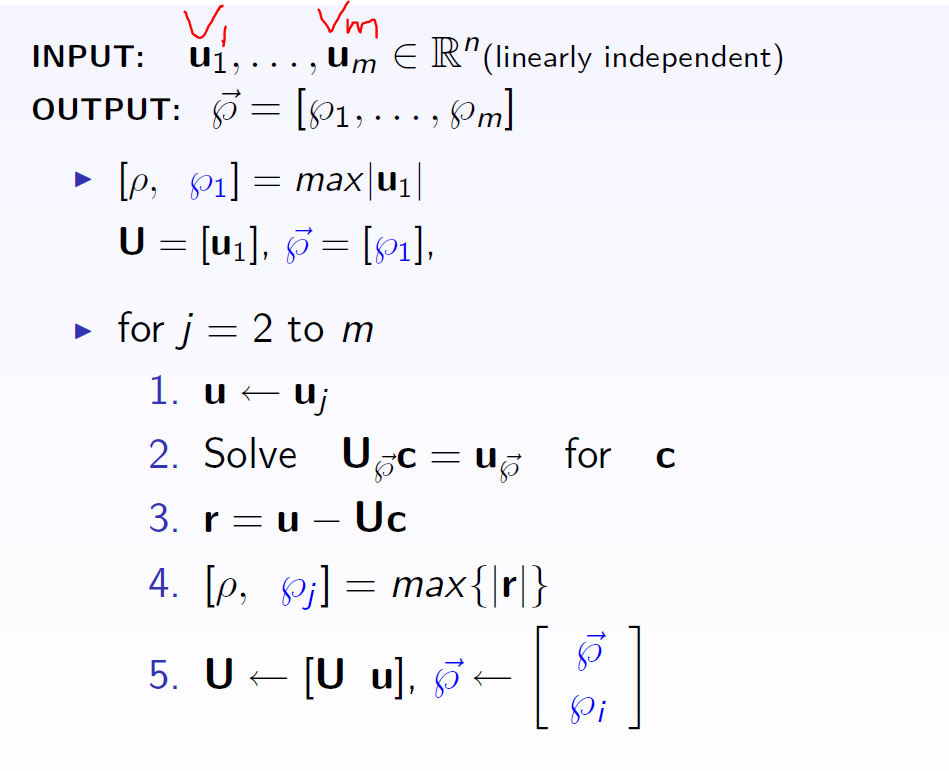

201 3
DEIM Cycle:  0


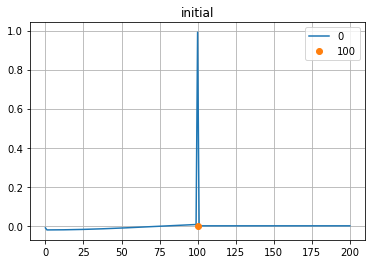

DEIM Cycle:  1


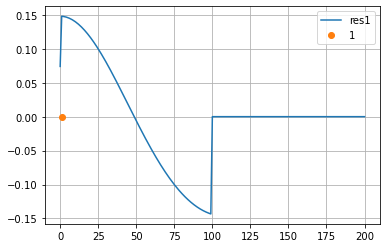

DEIM Cycle:  2


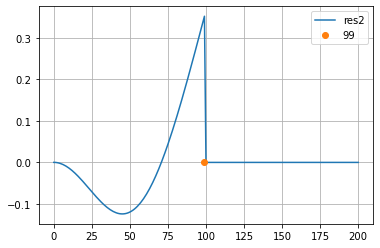

[100   1  99]


In [384]:
def DEIM_SVD_plot(u_in):
    [n, r] = np.shape(u_in)
    print(n,r)
    P, list_ind = np.zeros([n,r]), np.zeros(r,dtype=int)
    
    ind = np.argmax(np.abs(u_in[:, 0]))
    
    print('DEIM Cycle: ', 0)
    P[ind,0] = 1
    BB = np.expand_dims(u_in[:,0],axis=1)
    list_ind[0]= ind

    plt.figure()
    plt.plot(BB[:,0],label=str(0))
    plt.plot(ind,0,'o',label=str(ind))
    plt.grid(True)
    plt.legend()
    plt.title('initial')
    plt.show()
    
    for i in range(1,r):
        print('DEIM Cycle: ', i)
        P_loc, u_i = P[:,:i], u_in[:,i]        
        mat = P_loc.T @ BB
        rhs = P_loc.T @ u_i
        c = np.linalg.solve(mat, rhs)
        residual = u_i - BB@c
        ind = np.argmax(np.abs(residual))
        
        plt.figure()
        plt.plot(residual,label='res'+str(i))
        plt.plot(ind,0,'o',label=str(ind))
        plt.grid(True)
        plt.legend()
        plt.show()
        
        BB = np.hstack((BB, np.expand_dims(u_i,axis=1)))
        P[ind,i] = 1
        list_ind[i] = ind
    print(list_ind)
    return  list_ind

list_ind = DEIM_SVD_plot(V)

# demistifying DEIM
In DEIM, we compute
$$F(U_Tc_T) \approx U_F (P^t U_F)^{-1} P^t F(U_Tc)$$
- Matrix $M=U_T^t U_F (P^t U_F)^{-1}$ can be computed once for all.
- $P^t F(U_Tc)$ is just a selection of a few rows of $F$ based on the selector matrix $P$.


We can view the approximation as
$$F(U_Tc_T) = U_F c_F$$
Thus the $c_F$ vector is
$$c_F = U_F^t F(U_Tc_T) = U_F^t U_F (P^t U_F)^{-1} P^t F(U_Tc)$$

$U_F (P^t U_F)^{-1} P^t$ is an oblique projection onto span of $U_F$

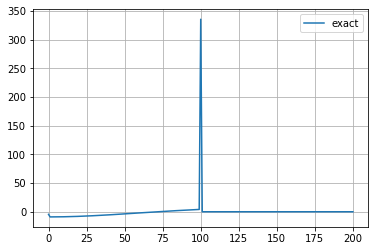

(3, 3)


In [385]:
plt.figure()
plt.plot(Fsnap[:,my_sample],'-',label='exact')
plt.grid(True)
plt.legend()
plt.show()

MM =  np.linalg.inv(P.T@V)
print(MM.shape)

In [390]:
type(list_ind)

numpy.ndarray

c for T [-6.61102702e+03  3.76473991e+02 -4.35415902e+01  6.33578845e+00]
c for F: [ 3.39494251e+02 -1.26748719e+01 -2.04221497e-01]


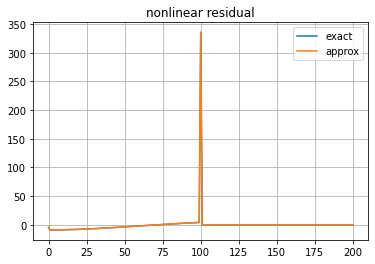

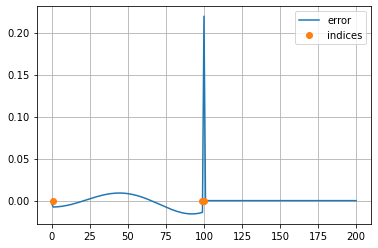

In [391]:
# snapshot temperature
T = Usnap[:,my_sample]
# associated expansion coefficients for T
c_T = U.T @ T
print('c for T',c_T)

# nonlinear residual at 'magic' points
PtF = deim_res(c_T,k1,mat2cell,list_ind,U)
# print(PtF)
# print(PtF.shape)
# making up expansion coefficients for F
c_F = MM @ PtF
print('c for F:',c_F)

Fapprox = V @ c_F
plt.figure()
plt.plot(Fsnap[:,my_sample],'-',label='exact')
plt.plot(Fapprox,'-',label='approx')
plt.grid(True)
plt.title('nonlinear residual')
plt.legend()
plt.show()

plt.figure()
plt.plot(Fsnap[:,my_sample]-Fapprox,'-',label='error')
plt.plot(list_ind,np.zeros(len(list_ind)),'o',label='indices')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
# for i in range(rF):
#     plt.figure()
#     plt.plot(V[:,i],'-',label=str(list_ind[i]))
#     plt.plot(np.array(list_ind[:i+1],dtype=float),np.zeros(i+1),'o')
#     plt.grid(True)
#     plt.legend()
# plt.show()

# for i in range(rF):
#     plt.figure()
#     Fapprox = V[:,:i+1] @ c_F[:i+1]
#     lab = 'Fapprox '+str(i)+' ind='+str(list_ind[i])
#     plt.plot(Fapprox-Fsnap[:,my_sample],'-',label=lab)
#     plt.plot(np.array(list_ind[:i+1],dtype=float),np.zeros(i+1),'o')
#     plt.grid(True)
#     plt.legend()
# plt.show()